In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
#from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten, Conv1D, MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
items = pd.read_csv("/content/drive/MyDrive/Final year project code/20190928-items.csv")
reviews = pd.read_csv("/content/drive/MyDrive/Final year project code/20190928-reviews.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Items overview
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(items.shape))
items.head()

The dataset contains  792 rows and  9 variables.


,asin,brand,title,url,image,rating,reviewUrl,totalReviews,prices
0,B0000SX2UC,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,2.9,https://www.amazon.com/product-reviews/B0009N5L7K,7,$49.95
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.6,https://www.amazon.com/product-reviews/B000SKTZ0S,22,NaN
3,B00198M12M,Nokia,Nokia 6500 Slide Black/silver Unlocked Cell Phone,https://www.amazon.com/Nokia-6500-Slide-silver...,https://m.media-amazon.com/images/I/41ss4HpLkL...,2.4,https://www.amazon.com/product-reviews/B00198M12M,5,NaN
4,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,NaN


In [ ]:
items.describe(include="all")

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,prices
count,792,792,792,792,792,792.000000,792,792.000000,577
unique,792,10,785,792,719,NaN,792,NaN,447
top,B0000SX2UC,Samsung,Samsung Galaxy S8 SM-G950U 64GB for T-Mobile (...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/81mE4HPNGf...,NaN,https://www.amazon.com/product-reviews/B0000SX2UC,NaN,$199.99
freq,1,397,3,1,4,NaN,1,NaN,8
mean,NaN,NaN,NaN,NaN,NaN,3.607576,NaN,104.231061,NaN
std,NaN,NaN,NaN,NaN,NaN,0.668730,NaN,166.242503,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.200000,NaN,7.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,3.700000,NaN,31.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,122.250000,NaN


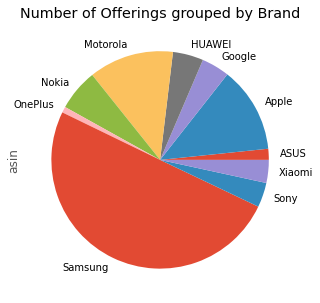

In [ ]:
plt.style.use("ggplot")
# Brand distribution
ax = items.groupby("brand").count()["asin"].plot(kind="pie",figsize=(8, 5),title="Number of Offerings grouped by Brand")
plt.show()

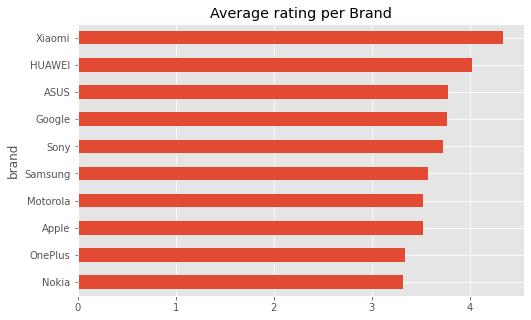

In [ ]:
# Average rating per brand
ax = items.groupby("brand").mean()["rating"].sort_values().plot(kind="barh",figsize=(8,5),title="Average rating per Brand")
plt.show()

In [ ]:
# Reviews overview
print("The dataset contains {0[0]: ,.0f} rows and {0[1]: .0f} variables.".format(reviews.shape))
reviews.head()

The dataset contains  82,815 rows and  8 variables.


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [5]:
# Link review data to item data bsed on common column "asin"
reviews = pd.merge(reviews, items, how="left", left_on="asin", right_on="asin")

In [6]:
# Rename columns
reviews.rename(columns={"rating_x": "rating", "title_x": "title", "title_y": "item_title", "rating_y": "overall_rating"}, inplace=True)
reviews.head()

,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,prices
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN


In [ ]:
# Convert string into datetime
from datetime import datetime
reviews["date"] = reviews["date"].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
reviews["date"].head()

0   2005-10-11
1   2004-01-07
2   2003-12-30
3   2004-03-18
4   2005-08-28
Name: date, dtype: datetime64[ns]

In [ ]:
# Truncate date column to month
reviews["year"] = reviews["date"].apply(lambda x: x.replace(day=1))
reviews["year"].head()

0   2005-10-01
1   2004-01-01
2   2003-12-01
3   2004-03-01
4   2005-08-01
Name: year, dtype: datetime64[ns]

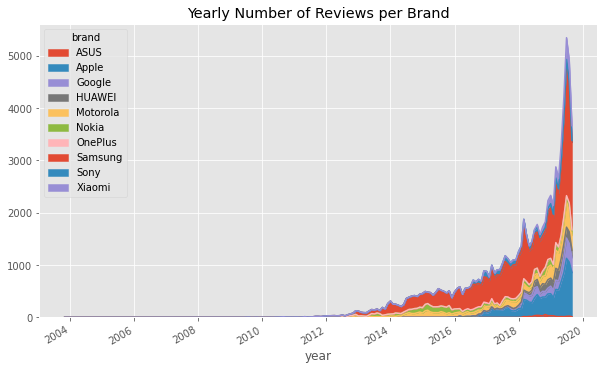

In [ ]:
# 0.8 Plot reviews over time
ax = pd.pivot_table(reviews, 
                    index="year", 
                    columns="brand", 
                    values="asin", 
                    aggfunc="count", 
                    fill_value=0).plot.area(title="Yearly Number of Reviews per Brand", figsize=(10, 6))

In [7]:
# 0.9 Add posivity label
# Creating a new column sentiment based on overall ratings
def sentiments(reviews):
    if reviews["rating"] > 3.0:
        return 1
    elif reviews["rating"] <= 3.0:
        return 0
reviews["positivity"] = reviews.apply(sentiments, axis=1)

In [8]:
# Step 1: Preprocess review text
# 1.1 Define preprocess function
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList = text.split()
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stop]
    # Remove other keywords
    wordList = [word for word in wordList if word not in keywords]
    # Lemmatisation
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I love reading books.")

'love reading book'

In [9]:
# 1.2 Apply preprocess function to the dataframe
reviews["body"] = reviews["body"].astype("str")
reviews["clean_text"] = reviews["body"].apply(clean_text)

In [ ]:
reviews["clean_text"].head()

0    a600 awhile absolute doo doo read review detec...
1    due software issue sprint phone's text messagi...
2    great reliable also purchased a460 died menu e...
3    love really need one expect price bill receive...
4    great every purpose offer except day bought it...
Name: clean_text, dtype: object

In [ ]:
# Step 2: Create a wordcloud
# 2.1 Define word frequency function
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict
word_freq_dict("I love reading books. I love music.")

{'I': 2, 'books.': 1, 'love': 2, 'music.': 1, 'reading': 1}

In [ ]:
# 2.2 Create brand subsets
apple = reviews[reviews["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
samsung = reviews[reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)
xiaomi = reviews[reviews["brand"]=="Xiaomi"].sort_values(by=["date"], ascending=False)

In [ ]:
# 2.3 Initializer
from wordcloud import WordCloud, ImageColorGenerator

# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
# Define a function to plot top10 positive words and top10 negative words in a grouped bar plot (from dictionaries)
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

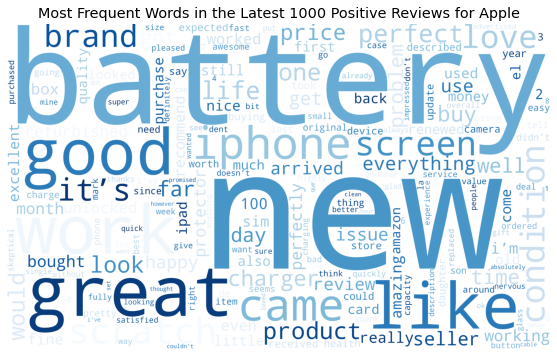

In [ ]:
# 2.4 Plot wordclouds for latest 1000 reviews for Apple
apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"][0:1000])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Apple")

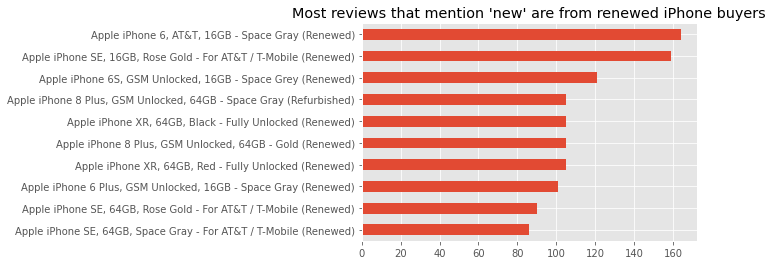

In [ ]:
apple[apple["clean_text"].apply(lambda x: "new" in x)]["item_title"].value_counts().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Most reviews that mention 'new' are from renewed iPhone buyers")
plt.show()

In [ ]:
apple["renewed"] = apple["item_title"].apply(lambda x: ("Renewed" in x) | ("Reburshied" in x))
print("{0: 0.1%} iPhones that were sold on Amazon are renewed/reburshied.".format(apple["renewed"].sum() / len(apple["renewed"])))

 96.3% iPhones that were sold on Amazon are renewed/reburshied.


In [ ]:
apple_neg = " ".join(apple[apple["positivity"]==0]["clean_text"][0:1000])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="black")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Apple")

ValueError: ignored

In [ ]:
topn_wordfreq_bar_both(apple_pos_word_freq, apple_neg_word_freq, 
                       min(sum(apple["positivity"]==1), 1000), 
                       min(sum(apple["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Apple", 
                       ["lightblue", "lightcoral"], 
                       height=6, aspect=2)

KeyError: ignored

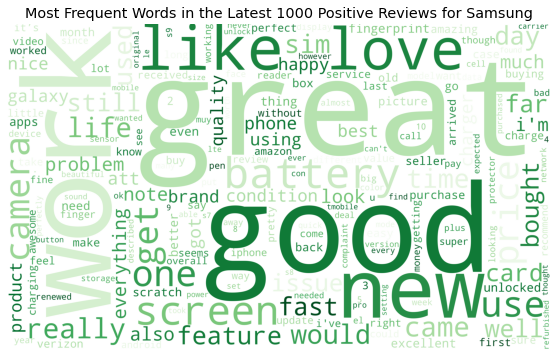

In [ ]:
# 2.5 Plot wordclouds for latest 1000 reviews for Samsung
samsung_pos = " ".join(samsung[samsung["positivity"]==1]["clean_text"][0:1000])
samsung_pos_word_freq = word_freq_dict(samsung_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="white")
wordcloud_from_frequency(samsung_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

In [ ]:
samsung_neg = " ".join(samsung[samsung["positivity"]==-1]["clean_text"][0:1000])
samsung_neg_word_freq = word_freq_dict(samsung_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="black")
wordcloud_from_frequency(samsung_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")

ValueError: ignored

In [ ]:
topn_wordfreq_bar_both(samsung_pos_word_freq, samsung_neg_word_freq, 
                       min(sum(samsung["positivity"]==1), 1000), 
                       min(sum(samsung["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Samsung", 
                       ["steelblue", "orange"], 
                       height=6, aspect=2)

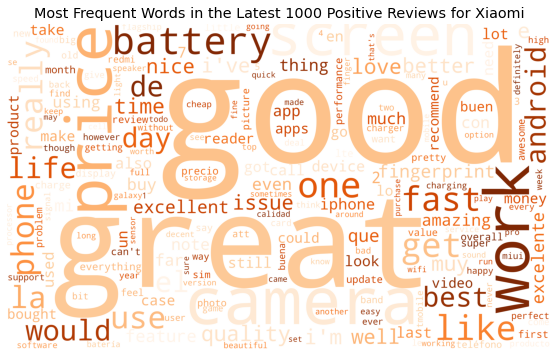

In [ ]:
# 2.6 Plot wordclouds for latest 1000 reviews for Xiaomi
xiaomi_pos = " ".join(xiaomi[xiaomi["positivity"]==1]["clean_text"][0:1000])
xiaomi_pos_word_freq = word_freq_dict(xiaomi_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Oranges",
                      background_color="white")
wordcloud_from_frequency(xiaomi_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Xiaomi")

In [ ]:
xiaomi_neg = " ".join(xiaomi[xiaomi["positivity"]==-1]["clean_text"][0:1000])
xiaomi_neg_word_freq = word_freq_dict(xiaomi_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Oranges",
                      background_color="black")
wordcloud_from_frequency(xiaomi_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Xiaomi")

ValueError: ignored

In [ ]:
topn_wordfreq_bar_both(xiaomi_pos_word_freq, xiaomi_neg_word_freq, 
                       min(sum(xiaomi["positivity"]==1), 1000), 
                       min(sum(xiaomi["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Xiaomi", 
                       ["darkgreen", "pink"], 
                       height=6, aspect=2)

KeyError: ignored

In [ ]:
# Step 3: Vectorization and Topic Modelling
# 3.1 Initialize TF-IDF vectorizer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

In [ ]:
# 3.2 Initalize LDA model
from sklearn.decomposition import LatentDirichletAllocation
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50, 
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [ ]:
# 3.3 Define a function to print LDA topics
def print_topn_words(model, feature_names, topn):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-topn - 1:-1]])
        print(message)
    print()

In [ ]:
# 3.4 Run LDA model for Apple
t0 = time.time()
apple_tfidf = tfidf_vectorizer.fit_transform(apple["clean_text"])
apple_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
lda.fit(apple_tfidf)
print("Below is the output from LDA model with {} topics (each includes Top10 words) for Apple.".format(n_topics))
print_topn_words(lda, apple_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below is the output from LDA model with 10 topics (each includes Top10 words) for Apple.
Topic #0: love perfect got work new iphone condition great seller scratch
Topic #1: great condition far price work new good problem perfect scratch
Topic #2: came scratch charger condition work new like brand good perfect
Topic #3: time bought month work problem working screen iphone use new
Topic #4: screen working issue day got seller scratch refurbished far battery
Topic #5: good use seller work new far iphone condition price look
Topic #6: work new look brand like great refurbished scratch iphone far
Topic #7: like buy new iphone great work refurbished seller screen got
Topic #8: product iphone refurbished price new work screen great look good
Topic #9: battery problem life work new iphone screen day good great

Done in 56.558s.


In [ ]:
# Run the model for Samsung
t0 = time.time()
samsung_tfidf = tfidf_vectorizer.fit_transform(samsung["clean_text"])
samsung_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
lda.fit(samsung_tfidf)
print("Below is the output from LDA model with {} topics (each includes Top10 words) for Samsung.".format(n_topics))
print_topn_words(lda, samsung_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below is the output from LDA model with 10 topics (each includes Top10 words) for Samsung.
Topic #0: issue note galaxy look day new like screen time great
Topic #1: good condition far really price great work time new got
Topic #2: great bought time price new work phone buy condition really
Topic #3: work fast great phone new got time really like buy
Topic #4: love price new great got really fast phone work good
Topic #5: unlocked problem month bought time buy got work phone new
Topic #6: screen came used new condition time got great work day
Topic #7: battery product buy got life great day time new phone
Topic #8: like new card sim work got buy condition great time
Topic #9: use camera battery screen like great good really time day

Done in 218.025s.


In [ ]:
# Run the model for Xiaomi
t0 = time.time()
xiaomi_tfidf = tfidf_vectorizer.fit_transform(xiaomi["clean_text"])
xiaomi_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
lda.fit(xiaomi_tfidf)
print("Below is the output from LDA model with {} topics (each includes Top10 words) for Xiaomi.".format(n_topics))
print_topn_words(lda, xiaomi_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below is the output from LDA model with 10 topics (each includes Top10 words) for Xiaomi.
Topic #0: excelente excellent product price camera fast work screen good battery
Topic #1: good really price need quality using camera battery fast screen
Topic #2: love nice battery life fast great camera good day screen
Topic #3: work use time problem issue bought month day screen good
Topic #4: amazing android quality camera screen price good great fast best
Topic #5: muy el la excelente android screen love product far price
Topic #6: great product feature work fast camera month price ve quality
Topic #7: money buy price come great better bought screen fast camera
Topic #8: best far better ve price phone fast battery day work
Topic #9: like device thing phone camera screen apps work good great

Done in 16.809s.


In [ ]:
# Step 1: Filter English reviews
# 1.1 Add language labels (This part can take ~15 minutes)
from langdetect import detect
def lang_detect(text):
    try:
        return detect(text)
    except:
        return None
import time
start_time = time.time()
reviews["lang"] = reviews["body"].apply(lang_detect)
print("It takes %s seconds for the code to finish." % (time.time() - start_time))

It takes 522.3564128875732 seconds for the code to finish.


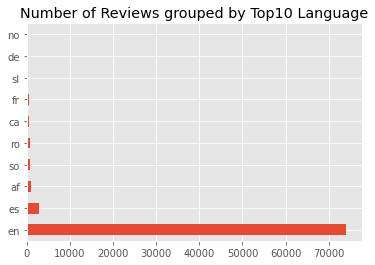

In [ ]:
# 1.2 Plot distribution of reviews into languages
reviews["lang"].value_counts()[:10].plot(kind="barh", title="Number of Reviews grouped by Top10 Language")
plt.show()

In [ ]:
# 1.3 Only take English reviews
reviews = reviews[reviews["lang"]=="en"]

In [ ]:
# Step 2: Sentiment analysis using Vader
# 2.1 Load packages
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("The weather is nice today.")

{'compound': 0.4215, 'neg': 0.0, 'neu': 0.588, 'pos': 0.412}

In [ ]:
# 2.2 Create sentiment score columns (It takes roughly 5 minutes)
start_time = time.time()
reviews["body"] = reviews["body"].astype("str")
reviews["sent_neg"] = reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["neg"])
reviews["sent_neu"] = reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
reviews["sent_pos"] = reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
reviews["sent_comp"] = reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
print("It takes %s seconds for the code to finish." % (time.time() - start_time))

It takes 213.16217064857483 seconds for the code to finish.


In [ ]:
# 2.3 Save the datasets into csv
reviews.to_csv("/content/drive/MyDrive/Final year project code/reviews_with_sentiment_scores.csv")

In [ ]:
# After the steps above we will get a pre-proceessed dataset
reviews_en = pd.read_csv("/content/drive/MyDrive/Final year project code/reviews_with_sentiment_scores.csv")

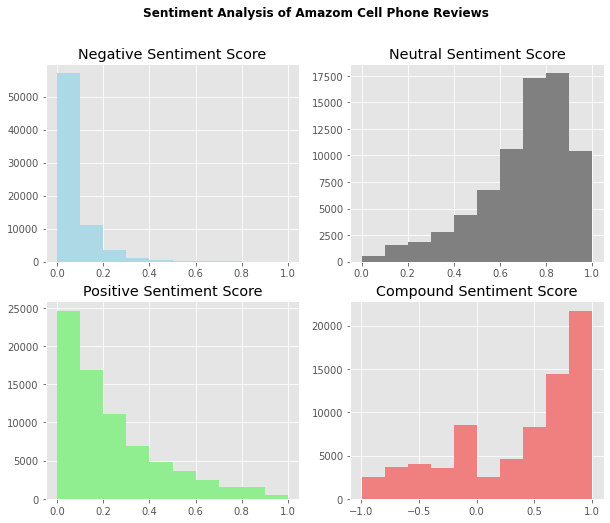

In [ ]:
# 2.4 Plot the distribution of sentiment scores
plt.figure()

plt.subplot(2, 2, 1)
reviews_en["sent_neg"].hist(figsize=(10, 8), color="lightblue")
plt.title("Negative Sentiment Score")
plt.subplot(2, 2, 2)
reviews_en["sent_neu"].hist(figsize=(10, 8), color="grey")
plt.title("Neutral Sentiment Score")
plt.subplot(2, 2, 3)
reviews_en["sent_pos"].hist(figsize=(10, 8), color="lightgreen")
plt.title("Positive Sentiment Score")
plt.subplot(2, 2, 4)
reviews_en["sent_comp"].hist(figsize=(10, 8), color="lightcoral")
plt.title("Compound Sentiment Score")

plt.suptitle('Sentiment Analysis of Amazom Cell Phone Reviews', fontsize=12, fontweight='bold');

plt.show()

The correlation coefficient between sentiment score (compound) and rating is  0.6092 with a p-value of  0.0000.


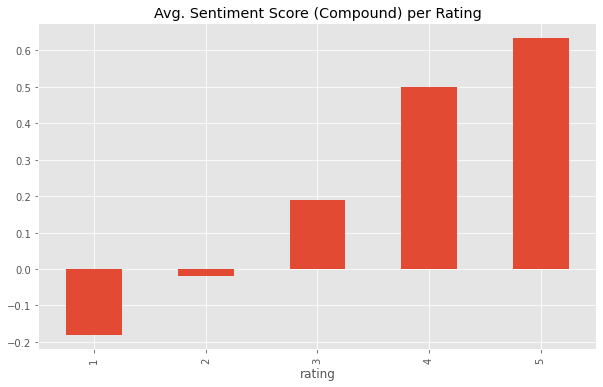

In [ ]:
# 2.5 Check the correlation between sentiment score (compound) and rating
import numpy as np
import scipy.stats as stats
print("The correlation coefficient between sentiment score (compound) and rating is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(reviews_en["rating"], reviews_en["sent_comp"])))
reviews_en.groupby("rating").mean()["sent_comp"].plot(kind="bar", figsize=(10, 6))
plt.title("Avg. Sentiment Score (Compound) per Rating")
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


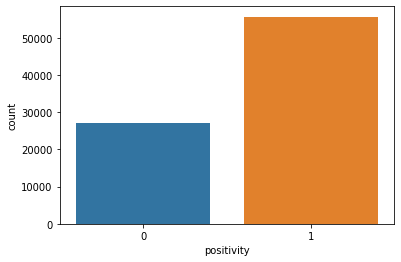

In [10]:
sns.countplot(reviews['positivity']);

In [11]:
data_cleaned = reviews[['clean_text','positivity']]

In [12]:
vocab_size = 20000
embedding_dim = 300
max_length = 500
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
texts = []
n = reviews["clean_text"].shape[0]
for i in range(n):
    s = reviews["clean_text"].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=max_length,lower=True, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

print('Number of tokens: ' + str(len(word_index)))

Number of tokens: 48937


In [13]:
train1, test1 = train_test_split(data_cleaned,random_state=69, test_size=0.3)
training_sentences = []
testing_sentences = []



train_sentences=train1['clean_text'].values
train_labels=train1['positivity'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)

test_sentences=test1['clean_text'].values
test_labels=test1['positivity'].values
test_label=test_labels
for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.np_utils.to_categorical(train_labels)


test_labels=keras.utils.np_utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 57970
Testing Set Length: 24845
training_sentences shape: (57970,)
testing_sentences shape: (24845,)
train_labels shape: (57970, 2)
test_labels shape: (24845, 2)


In [ ]:
print(training_sentences[1])
print(train_labels[0])

4 andn12 month charge highly disappointed see anyway contact seller
[0. 1.]


In [ ]:
print(training_sentences.shape)
print(train_labels.shape)

(59125,)
(59125, 2)


In [14]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

40040
Word index length:40040


In [ ]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

love definitely would buy

Sentence Tokenized and Converted into Sequence :--> 

[15, 203, 13, 30]

After Padding the Sequence with padding length 100 :--> 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  15 203  13  30]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (66252, 500)
Padded shape(testing): (16563, 500)


In [15]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(64, kernel_size=3, activation = "relu"))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.10))
    model.add(MaxPooling1D(2,2))
    
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.10))
    
    model.add(LSTM(32))
    model.add(Dense(16, activation='relu'))
    model.add(Flatten())
    
    #l2 regularizer
    model.add(Dense(8 ,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='sigmoid'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    #adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0005),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          6000000   
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           57664     
                                                                 
 batch_normalization (BatchN  (None, 498, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 249, 64)           3

In [16]:
history=model.fit(padded,train_labels,epochs=5,batch_size=64,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
906/906 [==============================] - 121s 112ms/step - loss: 0.4050 - accuracy: 0.8578 - val_loss: 0.2834 - val_accuracy: 0.8926
Epoch 2/5
906/906 [==============================] - 98s 108ms/step - loss: 0.2286 - accuracy: 0.9196 - val_loss: 0.2697 - val_accuracy: 0.8961
Epoch 3/5
906/906 [==============================] - 98s 109ms/step - loss: 0.1618 - accuracy: 0.9479 - val_loss: 0.2939 - val_accuracy: 0.8940
Epoch 4/5
906/906 [==============================] - 98s 108ms/step - loss: 0.1142 - accuracy: 0.9654 - val_loss: 0.3308 - val_accuracy: 0.8904
Epoch 5/5
906/906 [==============================] - 98s 108ms/step - loss: 0.0858 - accuracy: 0.9751 - val_loss: 0.3520 - val_accuracy: 0.8888


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


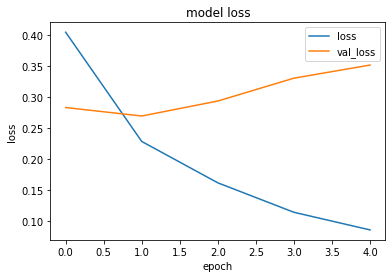

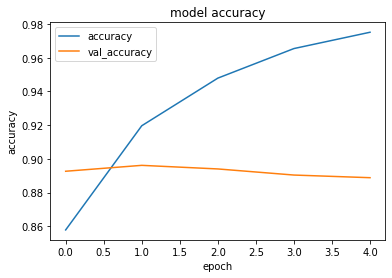

In [17]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [18]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))

906/906 [==============================] - 39s 43ms/step - loss: 0.0606 - accuracy: 0.9850
The train accuracy is: 0.985009491443634
389/389 [==============================] - 17s 45ms/step - loss: 0.3520 - accuracy: 0.8888
The test accuracy is: 0.888790488243103


In [ ]:
model.save('/content/drive/MyDrive/Final year project code/CNN_LSTM.h5')

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
import numpy as np
# load weights into new model
classifier = load_model('/content/drive/MyDrive/Final year project code/CNN_LSTM.h5')
print("Loading saved model...")

def predict_response(response):
    '''
    0 - negative
    1 - Positive

    '''
    print(f'You said: \n{response}\n')
    response = list(map(str, response))
    response = list(map(clean_text, response))
    
    response = tokenizer.texts_to_sequences(response)
    response = pad_sequences(response, maxlen=max_length)
    result = classifier.predict(response)
    pred = np.argmax(result)
    print(pred)
    print(result)
    if pred == 0:
        return 'Negative'
    elif pred == 1:
        return 'Positive'
    
       

Loading saved model...


In [25]:
user_input = input()
response = predict_response(response=[user_input])
print(response)

bad
You said: 
['bad']

1
[[0.41912046 0.72311044]]
Positive


In [19]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import math
# Calculation of Mean Squared Error (MSE)
mse = mse(accuracy, val_accuracy)
# Calculation of Mean Squared Error (MSE)
rmse = math.sqrt(mse)
# Calculation of Mean Squared Error (MSE)
mae = mae(accuracy, val_accuracy)

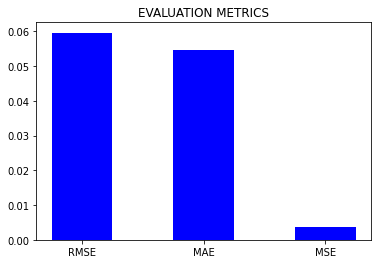

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset:
data = {'RMSE':rmse, 'MAE':mae, 'MSE':mse}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (6, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.5)
 
plt.title("EVALUATION METRICS")
plt.show()

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
    from numpy import unravel_index
    
   
    response = tokenizer.texts_to_sequences(testing_sentences)
    response = pad_sequences(response, maxlen=max_length)
    result = model.predict(response)
    pred = np.argmax(result,axis=1)

In [26]:
y_pred=pred

In [27]:
y_test=test_label

In [28]:
cm=confusion_matrix(y_pred,y_test)
print(cm)

[[ 3544  5804]
 [ 4707 10790]]


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.43      0.40      8251
           1       0.70      0.65      0.67     16594

    accuracy                           0.58     24845
   macro avg       0.54      0.54      0.54     24845
weighted avg       0.59      0.58      0.58     24845



In [30]:
print(accuracy_score(y_pred,y_test))

0.5769370094586436


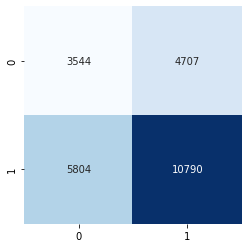

In [31]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)